<a href="https://colab.research.google.com/github/h-razu/air-quality-analysis/blob/main/air_quality_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the Required Library

In [109]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

## Task 01: Data Handling

#### Mount Google Drive and Load the Datasets

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
%cd '/content/drive/MyDrive/datasets/assessment_datasets'

/content/drive/MyDrive/datasets/assessment_datasets


In [112]:
%ls

air_quality_data_combined.csv
combined_output.csv
PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv


#### Randomly Select 5 Datasets and Merge them into One

In [113]:
# Get all files in the folder
files = os.listdir()

# Filter only CSV files that start with "PRSA_Data_"
csv_files = [file for file in files if file.startswith("PRSA_Data_") and file.endswith(".csv")]

# Choose 5 random CSV files
random_csv_files = random.sample(csv_files, 5)
selected_stations = [csv_file.split('_')[2] for csv_file in random_csv_files]

# Read and combine random selected CSV files
combined_df = pd.concat([pd.read_csv(file) for file in random_csv_files], ignore_index=True)

# Save to a new CSV file
combined_df.to_csv("air_quality_data_combined.csv", index=False)

print(f"CSV files containing {selected_stations} station have been merged into 'air_quality_data_combined.csv'.")

CSV files containing ['Tiantan', 'Nongzhanguan', 'Wanshouxigong', 'Huairou', 'Shunyi'] station have been merged into 'air_quality_data_combined.csv'.


#### Read the Merge Dataset

In [131]:
df = pd.read_csv("air_quality_data_combined.csv")
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
1,2,2013,3,1,1,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Tiantan
2,3,2013,3,1,2,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Tiantan
3,4,2013,3,1,3,6.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-25.5,0.0,N,4.9,Tiantan
4,5,2013,3,1,4,5.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Tiantan


## Task 02A: Data Understanding

In [163]:
print(f"DataFrame shape is: {df.shape}")

DataFrame shape is: (175320, 19)


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   year                  175320 non-null  float64 
 1   month                 175320 non-null  float64 
 2   PM2.5                 175320 non-null  float64 
 3   PM10                  175320 non-null  float64 
 4   SO2                   175320 non-null  float64 
 5   NO2                   175320 non-null  float64 
 6   CO                    175320 non-null  float64 
 7   O3                    175320 non-null  float64 
 8   TEMP                  175320 non-null  float64 
 9   PRES                  175320 non-null  float64 
 10  DEWP                  175320 non-null  float64 
 11  RAIN                  175320 non-null  float64 
 12  wd                    175320 non-null  object  
 13  WSPM                  175320 non-null  float64 
 14  st

In [165]:
#print data types
df_types = pd.DataFrame([df.dtypes], columns=df.columns)
df_types

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object,float64,category,float64,float64


In [166]:
# check duplicate value
df.duplicated().sum()

np.int64(0)

In [167]:
df['station'].value_counts()

,count
station,
Tiantan,35064
Nongzhanguan,35064
Wanshouxigong,35064
Huairou,35064
Shunyi,35064


###### Missing Values Summary:

In [168]:
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution
Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset shows that most columns have very few missing values (around 5%), with the most notable being the CO column. Other columns like PM2.5, PM10, SO2, and NO2 also have small amounts of missing data, ranging from 1.6% to 2.4%.

###### Missing Values Summary by Station

In [169]:
#station wise missing value percentage for each columns
df.groupby('station').apply(lambda g: g.isnull().mean() * 100).T.round(2).T

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution
station,,,,,,,,,,,,,,,,,,,
Huairou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nongzhanguan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shunyi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tiantan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wanshouxigong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset shows minimal missing values across all stations, with most columns like year, month, and station having no missing data. Air quality measurements such as PM2.5, PM10, and SO2 exhibit small missing value percentages, ranging from 1.66% to 5.74%. The CO column has the highest missing value percentage among the air quality metrics. Missing data is sparse and scattered across the stations, with no significant gaps in any specific station.

###### Visualize missing data as a heatmap:

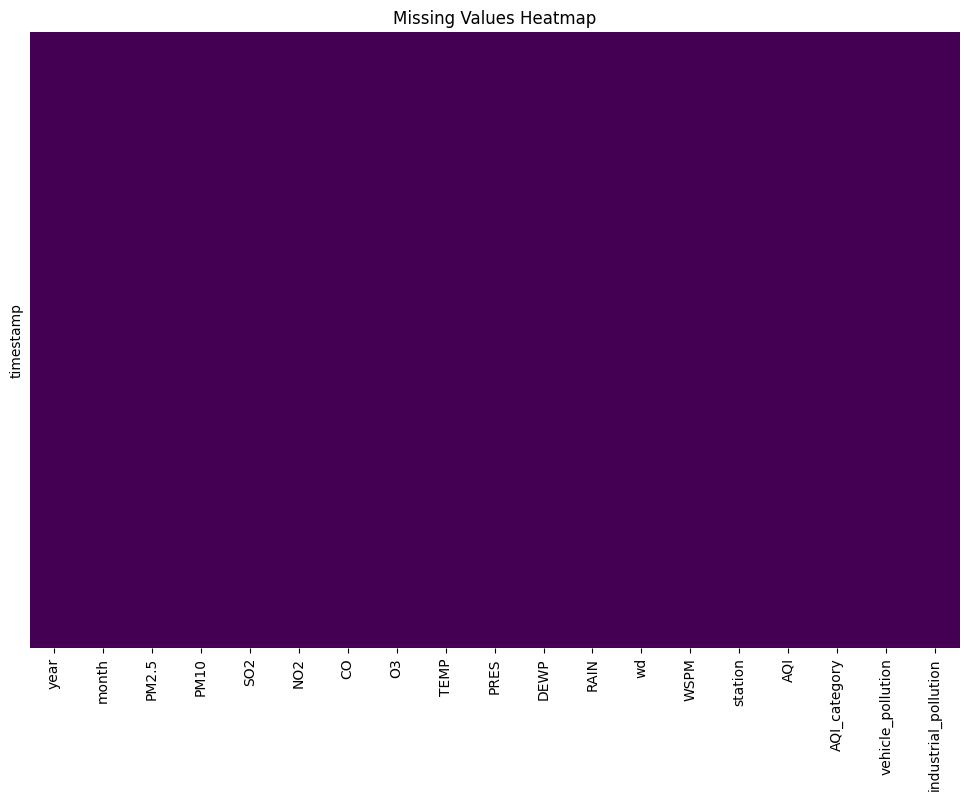

In [170]:
# Visualize missing data as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

## Task 02B: Data Preprocessing

#### Handling Missing Values:

Since the percentage of missing values in the dataset is relatively low (around 5%), imputing missing values is a suitable approach. This will help preserve all available data and prevent the loss of valuable information by removing rows. Imputation ensures that the dataset remains complete, allowing for more accurate and reliable model training. By imputing, we avoid potential biases that could be introduced by dropping rows, ensuring the integrity of the analysis. Additionally, since I am using lag features for more accurate predictions in the random forest model, imputing the missing values will help maintain the consistency of the time series data for better forecasting performance.

In [140]:
# Impute numerical columns with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create an imputer for numerical data
numerical_imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the numerical columns
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with the mode (most frequent value)
categorical_cols = df.select_dtypes(include=['object']).columns

# Create an imputer for categorical data
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply the imputer to the categorical columns
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

I use `SimpleImputer(strategy='mean')` to replace missing values in numerical columns with the mean of each column, ensuring that the imputed values are consistent with the data distribution. For categorical columns, I use `SimpleImputer(strategy='most_frequent')` to fill missing values with the most frequent value (mode), preserving the most common category in the dataset.

###### Inspect missing values again:

In [142]:
# Inspect missing values again
missing_values = pd.DataFrame([df.isna().sum(), ((df.isna().sum() / len(df))*100).round(3)], columns=df.columns)
missing_values.index = ['Count', 'Percentage']
missing_values

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Outliers Handling

###### Statistical Information

In [143]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No,175320.0,17532.500000,10122.133783,1.0000,8766.75,17532.5,26298.25,35064.0
year,175320.0,2014.662560,1.177200,2013.0000,2014.00,2015.0,2016.00,2017.0
month,175320.0,6.522930,3.448713,1.0000,4.00,7.0,10.00,12.0
day,175320.0,15.729637,8.800117,1.0000,8.00,16.0,23.00,31.0
hour,175320.0,11.500000,6.922206,0.0000,5.75,11.5,17.25,23.0
PM2.5,175320.0,80.247969,80.606126,2.0000,21.00,58.0,109.00,999.0
PM10,175320.0,103.581443,90.729545,2.0000,36.00,83.0,142.00,999.0
SO2,175320.0,15.197997,21.360215,0.2856,2.00,7.0,18.00,411.0
NO2,175320.0,48.743770,33.350438,1.0265,23.00,43.0,67.00,273.0
CO,175320.0,1241.079903,1128.504604,100.0000,500.00,900.0,1500.00,10000.0


###### Visualize Outiers

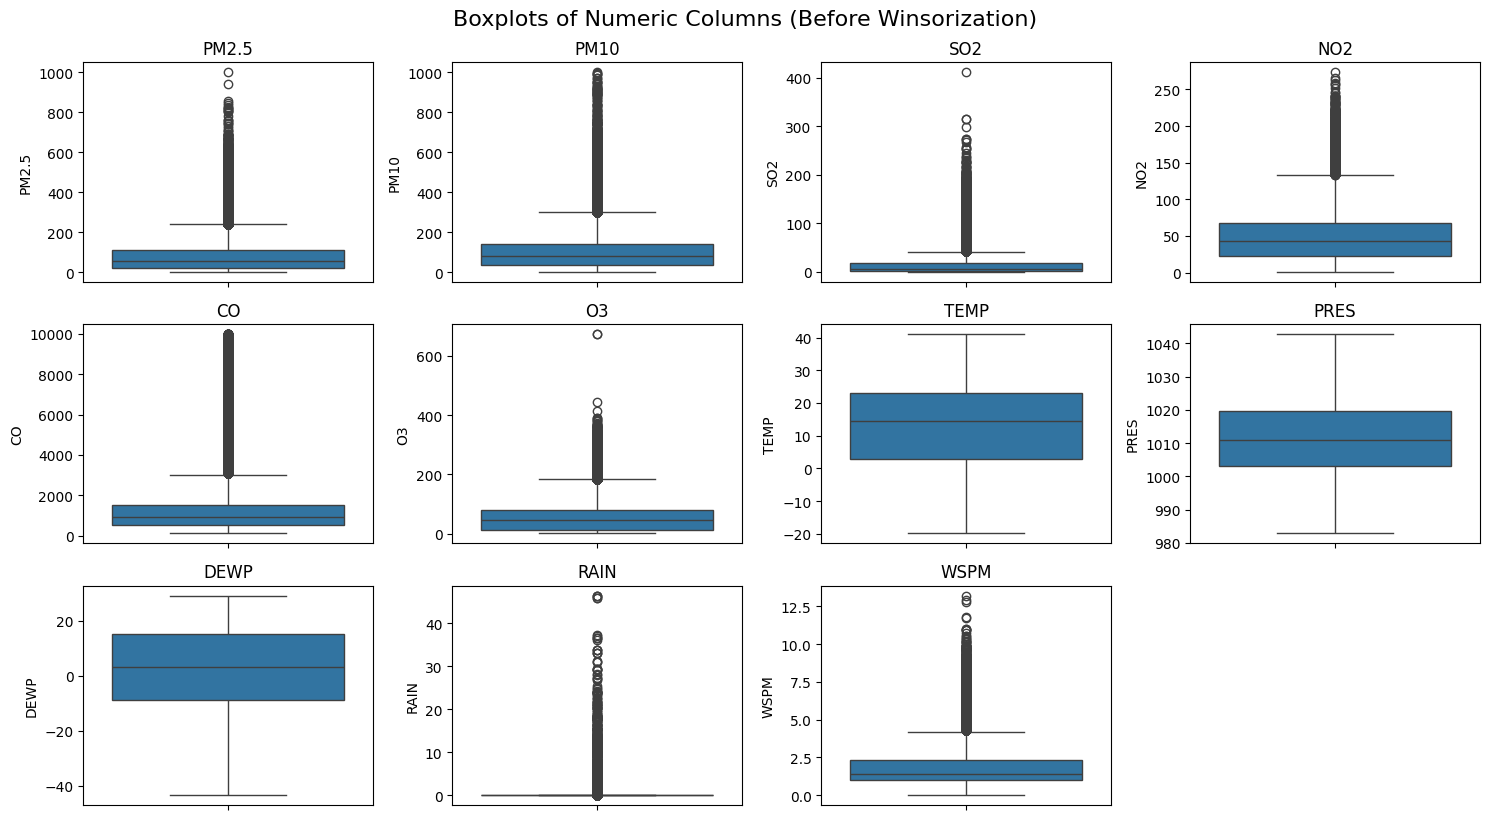

In [144]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include=['number']).columns.to_list()
numeric_cols.remove('No') # excluding `No` column
numeric_cols.remove('year') # excluding `year` column
numeric_cols.remove('month') # excluding `month` column
numeric_cols.remove('day') # excluding `day` column
numeric_cols.remove('hour') # excluding `hour` column

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle('Boxplots of Numeric Columns (Before Winsorization)', fontsize=16, y=1.02)
plt.show()

| Column          | Observation                                                                                      |
|------------------|--------------------------------------------------------------------------------------------------|
| **PM2.5**        | Many extreme outliers above 200 µg/m³, but still plausible in highly polluted areas.            |
| **PM10**         | Similar to PM2.5, lots of upper outliers; real-world events (e.g., dust storms) can explain these. |
| **SO2**          | Several upper outliers; SO₂ spikes can occur near industrial zones.                              |
| **NO2**          | Noticeable number of upper outliers; again possibly from traffic/urban activity.                |
| **CO**           | Very large outliers reaching 10,000; likely sensor error. |
| **O3**           | Some high outliers; ozone levels can peak midday but values seem extreme.                       |
| **TEMP, PRES, DEWP** | Distributions are clean with minimal or no outliers—no need for removal.                      |
| **RAIN**         | Some spikes—likely rare but valid rainfall events. Could be left in.                            |
| **WSPM**         | Wind speed has a few outliers but they appear within a reasonable range.                        |

###### IQR-Based Winsorization

In [60]:
# for col in numeric_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

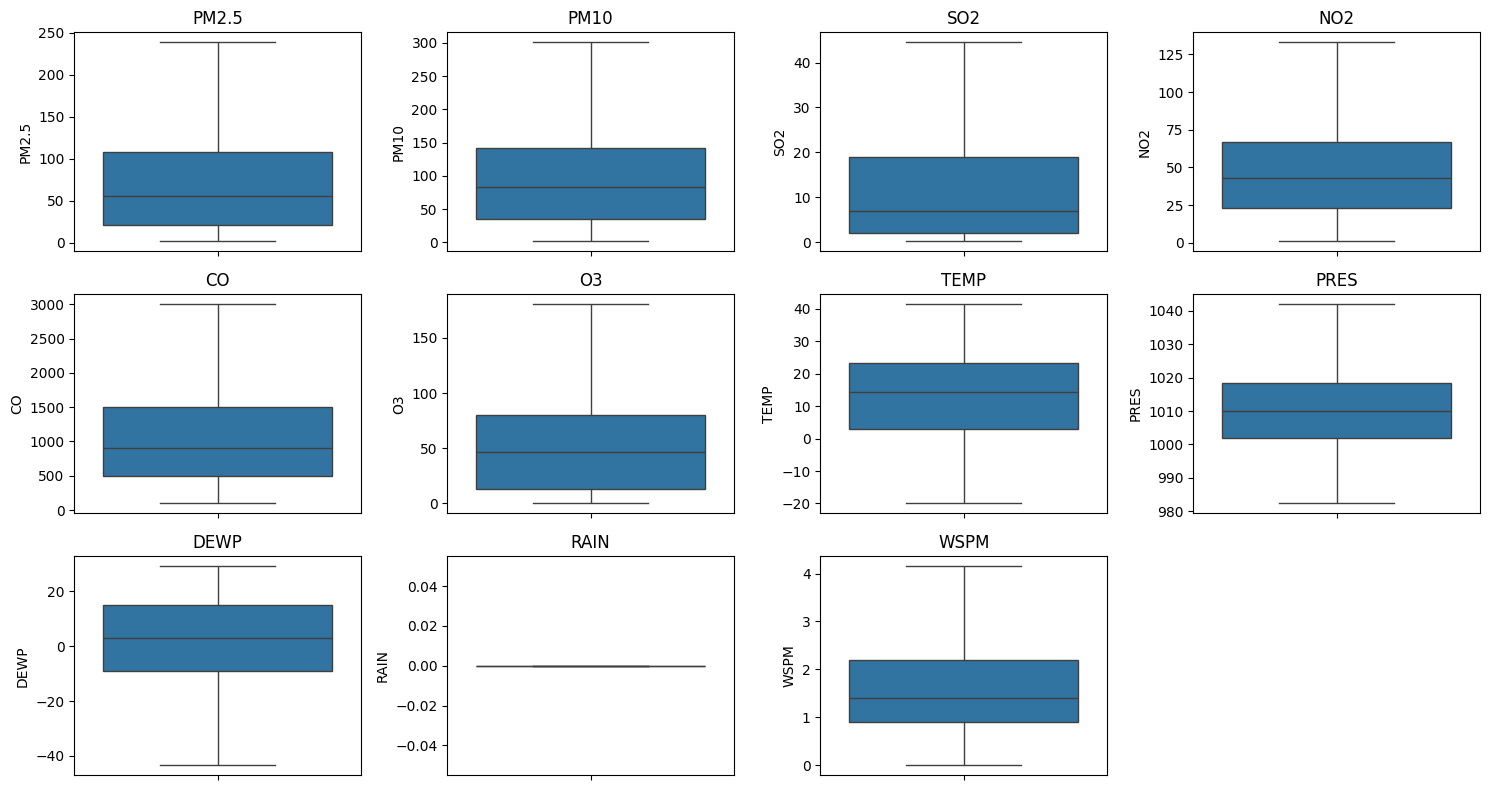

In [61]:
# plt.figure(figsize=(15, 8))
# for i, col in enumerate(numeric_cols, 1):
#     plt.subplot(3, 4, i)
#     sns.boxplot(y=df[col])
#     plt.title(col)
# plt.tight_layout()
# plt.show()

###### Percentile-Based Winsorization

Percentile-based winsorization caps the extreme values by replacing those below the 1st percentile and above the 99th percentile, making it suitable for skewed data like pollution and weather measurements. It preserves the overall dataset while reducing the influence of outliers that may distort analysis or model performance. In contrast, the IQR method uses the 25th and 75th percentiles to define a range and caps values outside of 1.5 times the IQR, which works better for normally distributed data. For environmental datasets, percentile-based capping is preferred because it’s more tolerant of natural but extreme fluctuations. It also helps maintain the data's integrity while improving stability in visualization and modeling.

In [145]:
# Winsorization (1st and 99th percentiles)
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower, upper=upper)

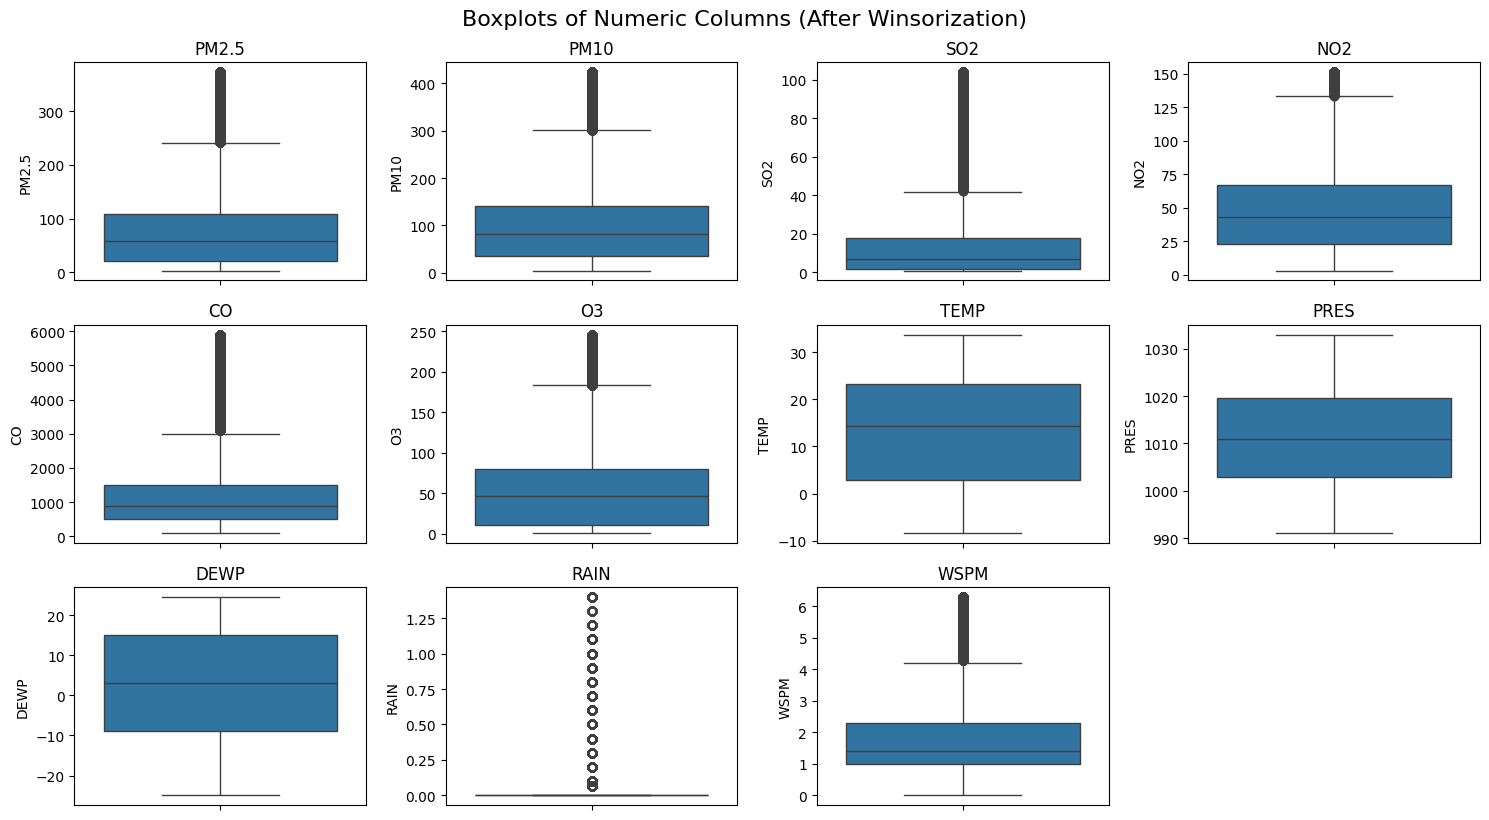

In [146]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle('Boxplots of Numeric Columns (After Winsorization)', fontsize=16, y=1.02)
plt.show()

#### Feature Extraction

###### Merge `year`, `month`, `day`, `hour` into `timestamp`. Convert it into datetime and set as index.

Converting the `year`, `month`, `day`, and `hour` into a datetime `timestamp` and using it as the index simplifies the data structure and enhances analysis. It allows for efficient time-based operations like filtering, resampling, and time series analysis. Storing the data as datetime reduces memory usage and ensures consistency, making it easier to work with time-related calculations. Using it as the index also helps in sorting and accessing data by specific time intervals, improving the overall efficiency of time-based analyses and visualizations.

In [147]:
# Create `timestamp` column
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set `timestamp` as the index
df = df.set_index('timestamp')

# Drop `No`, `day`, `hour`
df = df.drop(['No', 'day', 'hour'], axis=1)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
timestamp,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
2013-03-01 01:00:00,2013.0,3.0,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Tiantan
2013-03-01 02:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Tiantan
2013-03-01 03:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-24.9,0.0,N,4.9,Tiantan
2013-03-01 04:00:00,2013.0,3.0,5.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Tiantan


###### Calculate AQI (air quality index)

The Air Quality Index (AQI) is calculated by measuring the concentration of pollutants like ozone, particulate matter, sulfur dioxide, nitrogen dioxide, and carbon monoxide, then determining the highest sub-index value among these pollutants, which becomes the overall AQI.
[AQI on Wikipedia](https://en.wikipedia.org/wiki/Air_quality_index)

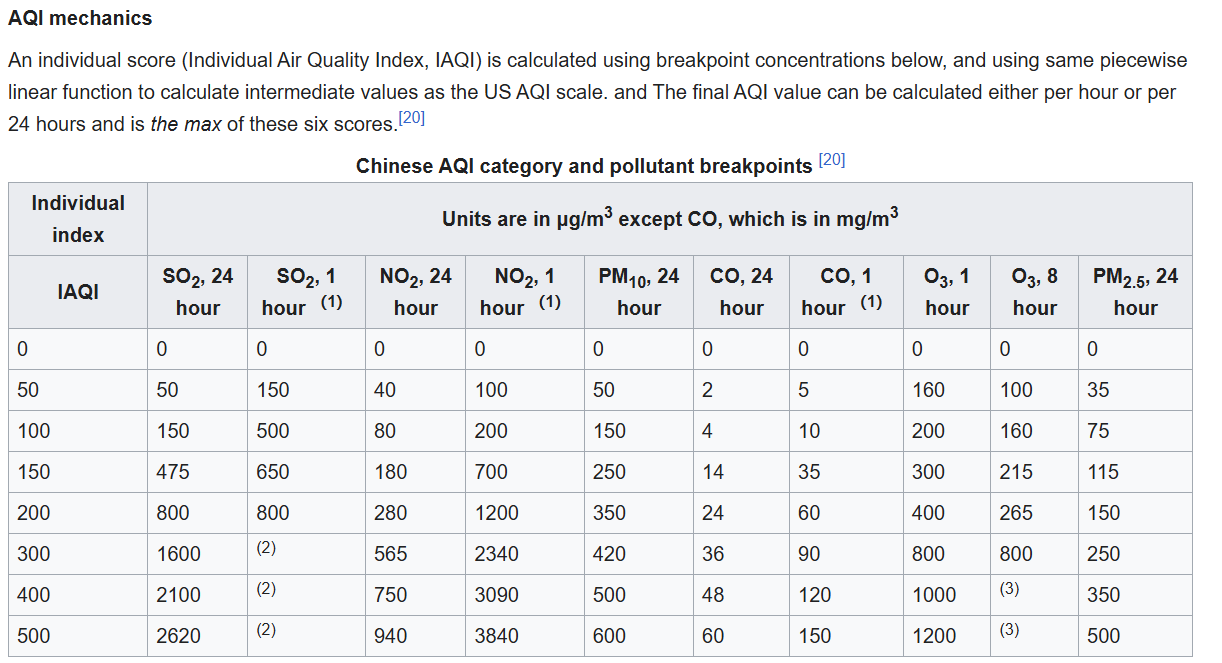

In [148]:
# breakpoint for calculating AQI for each one
breakpoints_pm25_per_day = [(0, 35, 0, 50), (35, 75, 51, 100), (75, 115, 101, 150), (115, 150, 151, 200),
                    (150, 250, 201, 300), (250, 350, 301, 400), (350, 500, 401, 500)]

breakpoints_pm10_per_day = [(0, 50, 0, 50), (51, 150, 51, 100), (151, 250, 101, 150), (251, 350, 151, 200),
                    (350, 420, 201, 300), (420, 500, 301, 400), (500, 600, 401, 500)]

breakpoints_so2_per_hour = [(0, 150, 0, 50), (151, 500, 51, 100), (501, 650, 101, 150), (651, 800, 151, 200),
                   (801, 1600, 201, 300), (1601, 2100, 301, 400), (2100, 2620, 401, 500)]

breakpoints_no2_per_hour = [(0, 100, 0, 50), (101, 200, 51, 100), (201, 700, 101, 150), (701, 1200, 151, 200),
                   (1201, 2340, 201, 300), (2341, 3090, 301, 400), (3091, 3840, 401, 500)]

breakpoints_co_per_hour = [(0, 5000, 0, 50), (5001, 10000, 51, 100), (10001, 35000, 101, 150), (35001, 60000, 151, 200),
                  (60001, 90000, 201, 300), (90001, 120000, 301, 400), (120001, 150000, 401, 500)]

breakpoints_o3_per_hour = [(0, 160, 0, 50), (161, 200, 51, 100), (201, 300, 101, 150), (301, 400, 151, 200),
                  (401, 800, 201, 300), (801, 1000, 301, 400), (1001, 1200, 401, 500)]

The Air Quality Index (AQI) is calculated using a formula that converts measured pollutant concentrations into a single index value, with the highest sub-index value determining the overall AQI.



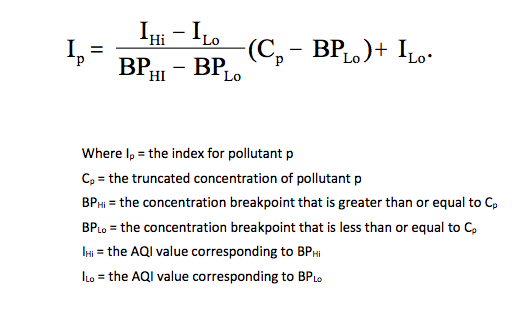

In [149]:
def calculate_aqi(conc, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= conc <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (conc - C_low) + I_low
    return np.nan

# 24-hour averages for PM2.5 and PM10
df['PM2.5_24h'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
df['PM10_24h'] = df['PM10'].rolling(window=24, min_periods=1).mean()

# AQI per pollutant
df['AQI_PM25'] = df['PM2.5_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm25_per_day))
df['AQI_PM10'] = df['PM10_24h'].apply(lambda x: calculate_aqi(x, breakpoints_pm10_per_day))
df['AQI_SO2'] = df['SO2'].apply(lambda x: calculate_aqi(x, breakpoints_so2_per_hour))
df['AQI_NO2'] = df['NO2'].apply(lambda x: calculate_aqi(x, breakpoints_no2_per_hour))
df['AQI_CO'] = df['CO'].apply(lambda x: calculate_aqi(x, breakpoints_co_per_hour))
df['AQI_O3'] = df['O3'].apply(lambda x: calculate_aqi(x, breakpoints_o3_per_hour))

# Final AQI: max value among all pollutants
df['AQI'] = df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3']].max(axis=1).round()

df[['AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3', 'AQI']].head()

,AQI_PM25,AQI_PM10,AQI_SO2,AQI_NO2,AQI_CO,AQI_O3,AQI
timestamp,,,,,,,
2013-03-01 00:00:00,8.571429,6.000000,1.333333,4.0,3.0,25.3125,25.0
2013-03-01 01:00:00,8.571429,17.500000,1.666667,4.5,3.0,25.0000,25.0
2013-03-01 02:00:00,8.571429,13.666667,1.333333,6.0,3.0,23.4375,23.0
2013-03-01 03:00:00,8.571429,11.750000,1.333333,6.0,3.0,23.1250,23.0
2013-03-01 04:00:00,8.285714,10.400000,2.333333,7.5,4.0,21.8750,22.0


In [150]:
# Keeping only `AQI` column, droping other column related to calculating AQI
df.drop(['PM2.5_24h', 'PM10_24h', 'AQI_PM25', 'AQI_PM10', 'AQI_SO2', 'AQI_NO2', 'AQI_CO', 'AQI_O3'], axis=1, inplace=True)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI
timestamp,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan,25.0
2013-03-01 01:00:00,2013.0,3.0,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Tiantan,25.0
2013-03-01 02:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Tiantan,23.0
2013-03-01 03:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-24.9,0.0,N,4.9,Tiantan,23.0
2013-03-01 04:00:00,2013.0,3.0,5.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Tiantan,22.0


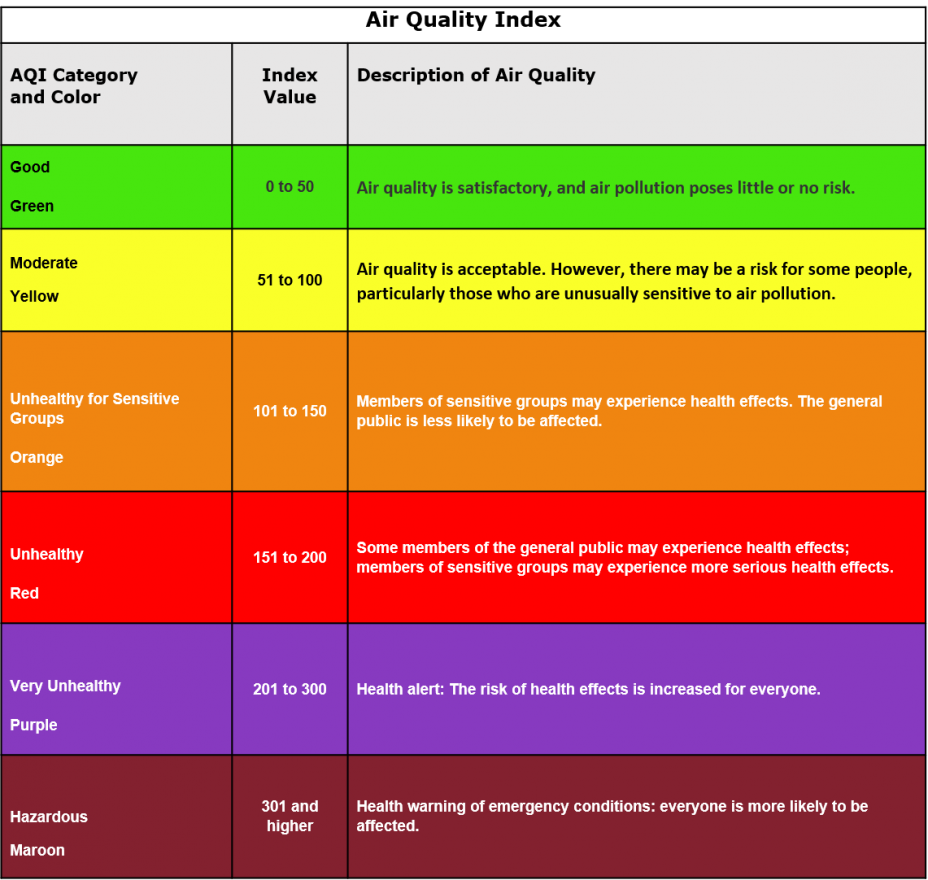

In [151]:
# create `AQI_lavel` column
bins = [0, 50, 100, 150, 200, 300, float('inf')]
labels = ['Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

df['AQI_category'] = pd.cut(df['AQI'], bins=bins, labels=labels, right=False)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category
timestamp,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan,25.0,Good
2013-03-01 01:00:00,2013.0,3.0,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Tiantan,25.0,Good
2013-03-01 02:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Tiantan,23.0,Good
2013-03-01 03:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-24.9,0.0,N,4.9,Tiantan,23.0,Good
2013-03-01 04:00:00,2013.0,3.0,5.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Tiantan,22.0,Good


###### Calculate `vehicle_pollution` and `industrial_pollution`

Summing specific pollutants to create `vehicle_pollution` and `industrial_pollution` variables is a practical approach to quantify pollution from these sources. `Vehicle_pollution` combines `PM2.5`, `PM10`, `NO2`, and `CO`, while `industrial_pollution` sums `SO2` and `O3`. This aggregation simplifies complex data, aiding in the analysis of trends and the development of targeted policies. However, the method assumes equal contribution from each pollutant within a category and requires consistent units.

In [152]:
df['vehicle_pollution'] = df[['PM2.5', 'PM10', 'NO2', 'CO']].sum(axis=1)
df['industrial_pollution'] = df[['SO2', 'O3']].sum(axis=1)

df.head()

,year,month,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,AQI,AQI_category,vehicle_pollution,industrial_pollution
timestamp,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013.0,3.0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan,25.0,Good,320.0,85.0
2013-03-01 01:00:00,2013.0,3.0,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Tiantan,25.0,Good,344.0,85.0
2013-03-01 02:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Tiantan,23.0,Good,324.0,79.0
2013-03-01 03:00:00,2013.0,3.0,6.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-24.9,0.0,N,4.9,Tiantan,23.0,Good,324.0,78.0
2013-03-01 04:00:00,2013.0,3.0,5.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Tiantan,22.0,Good,425.0,77.0


## Task 02C: Analysis and Visualisation

#### Average AQI per Year

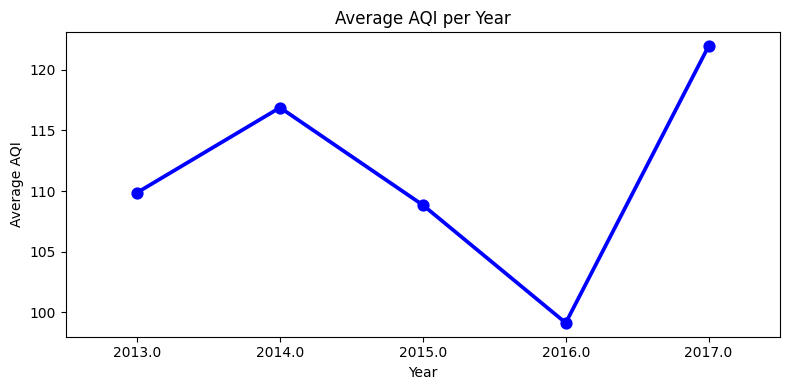

In [153]:
# Group by year and calculate mean AQI
yearly_avg = df.groupby('year')['AQI'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.pointplot(x='year', y='AQI', data=yearly_avg, color='blue', markers='o', linestyles='-')
plt.title('Average AQI per Year')
plt.ylabel('Average AQI')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

#### Average AQI per Year for each Station

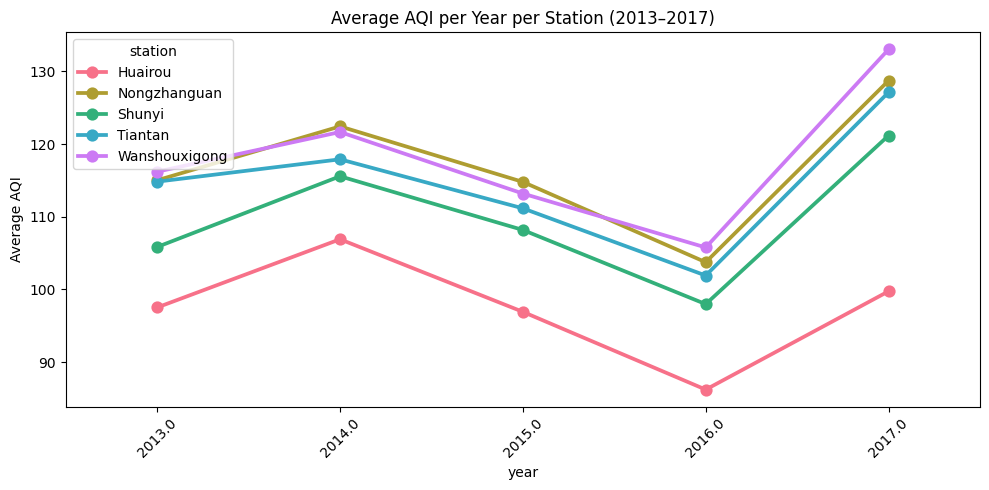

In [154]:
yearly_avg_by_station = df.groupby(['year', 'station'])['AQI'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.pointplot(data=yearly_avg_by_station, x='year', y='AQI', hue='station', palette='husl', linestyles='-')
plt.title('Average AQI per Year per Station (2013–2017)')
plt.ylabel('Average AQI')
plt.xlabel('year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Average Monthly AQI per Year (2013–2017)

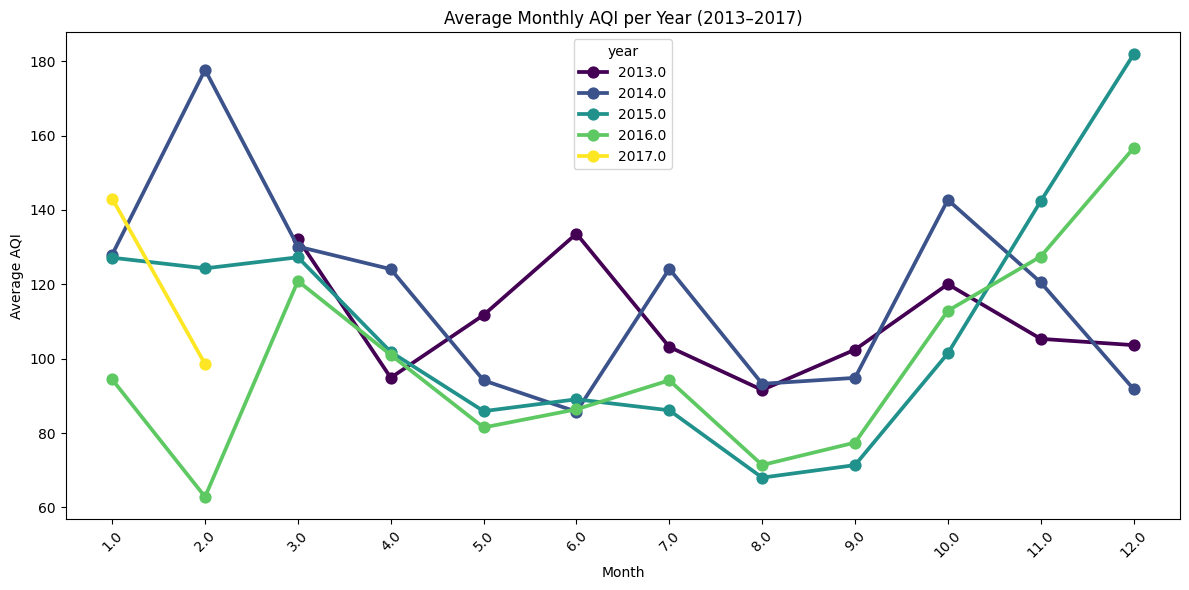

In [155]:
monthly_yearly_avg = df.groupby(['year', 'month'])['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.pointplot(data=monthly_yearly_avg, x='month', y='AQI', hue='year', palette='viridis', linestyles='-')
plt.title('Average Monthly AQI per Year (2013–2017)')
plt.ylabel('Average AQI')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Yearly Average Pollution Trend

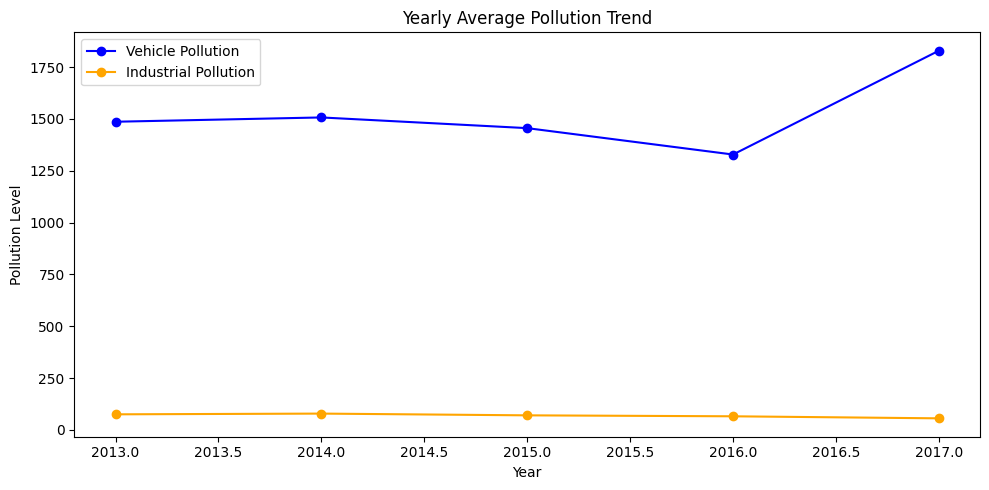

In [156]:
yearly_avg = df.groupby('year')[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(yearly_avg['year'], yearly_avg['vehicle_pollution'], marker='o', label='Vehicle Pollution', color='blue')
plt.plot(yearly_avg['year'], yearly_avg['industrial_pollution'], marker='o', label='Industrial Pollution', color='orange')
plt.title('Yearly Average Pollution Trend')
plt.xlabel('Year')
plt.ylabel('Pollution Level')
plt.legend()
plt.tight_layout()
plt.show()

#### Seasonal Pollution Pattern (Monthly Average)

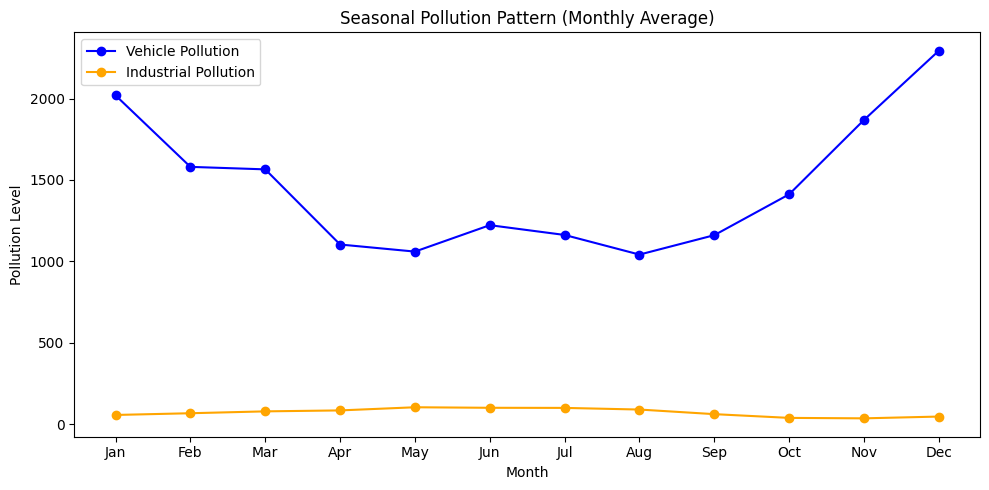

In [157]:
monthly_seasonal = df.groupby('month')[['vehicle_pollution', 'industrial_pollution']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_seasonal['month'], monthly_seasonal['vehicle_pollution'], marker='o', label='Vehicle Pollution', color='blue')
plt.plot(monthly_seasonal['month'], monthly_seasonal['industrial_pollution'], marker='o', label='Industrial Pollution', color='orange')
plt.title('Seasonal Pollution Pattern (Monthly Average)')
plt.xlabel('Month')
plt.ylabel('Pollution Level')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.tight_layout()
plt.show()

#### Vehicle vs Industrial Pollution Contribution by Year

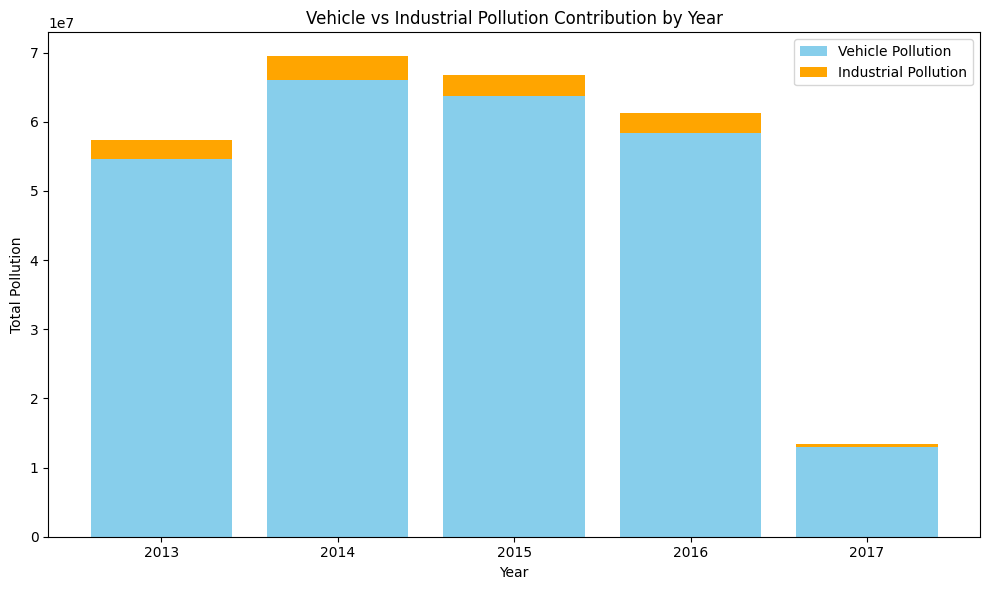

In [158]:
yearly_pollution = df.groupby('year')[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(yearly_pollution['year'], yearly_pollution['vehicle_pollution'], label='Vehicle Pollution', color='skyblue')
plt.bar(yearly_pollution['year'], yearly_pollution['industrial_pollution'],
        bottom=yearly_pollution['vehicle_pollution'], label='Industrial Pollution', color='orange')

plt.title('Vehicle vs Industrial Pollution Contribution by Year')
plt.xlabel('Year')
plt.ylabel('Total Pollution')
plt.legend()
plt.tight_layout()
plt.show()

#### Pollution Type Contribution by Station and Year

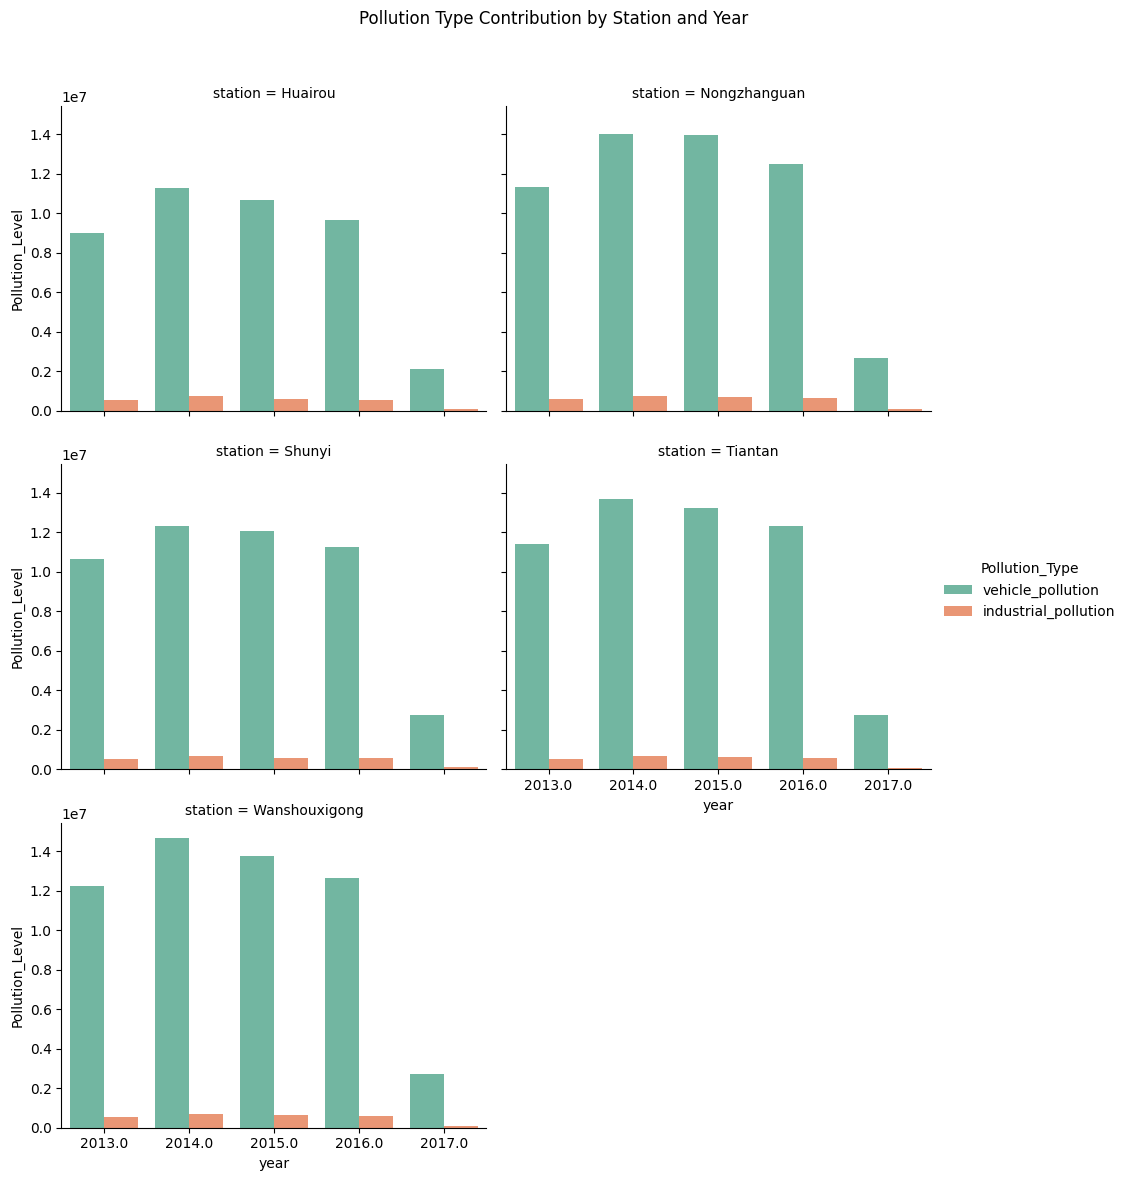

In [159]:
pollution_by_station_year = df.groupby(['station', 'year'])[['vehicle_pollution', 'industrial_pollution']].sum().reset_index()

df_melted = pollution_by_station_year.melt(
    id_vars=['station', 'year'],
    value_vars=['vehicle_pollution', 'industrial_pollution'],
    var_name='Pollution_Type',
    value_name='Pollution_Level'
)

g = sns.catplot(
    data=df_melted,
    x='year', y='Pollution_Level',
    hue='Pollution_Type',
    col='station',
    kind='bar',
    col_wrap=2,
    height=4,
    aspect=1.2,
    palette='Set2'
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Pollution Type Contribution by Station and Year')
plt.show()

#### RAIN impact on AQI

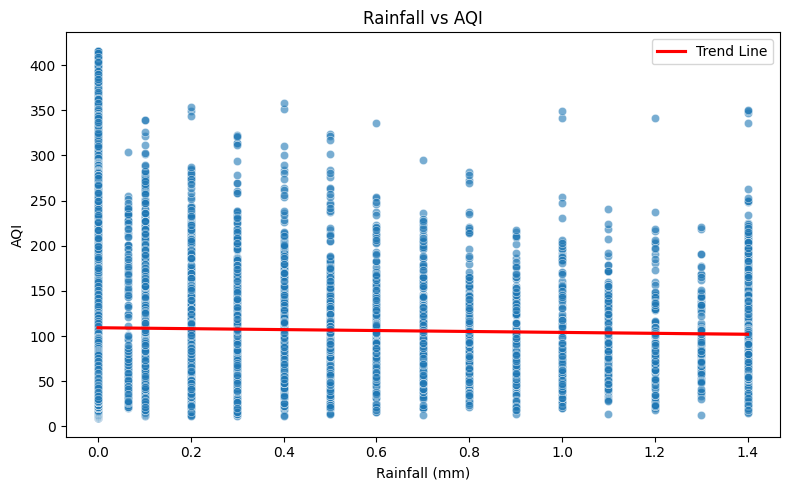

In [160]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='RAIN', y='AQI', alpha=0.6)
sns.regplot(data=df, x='RAIN', y='AQI', scatter=False, color='red', label='Trend Line')
plt.title('Rainfall vs AQI')
plt.xlabel('Rainfall (mm)')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()


#### RAIN vs Pollution Comparison

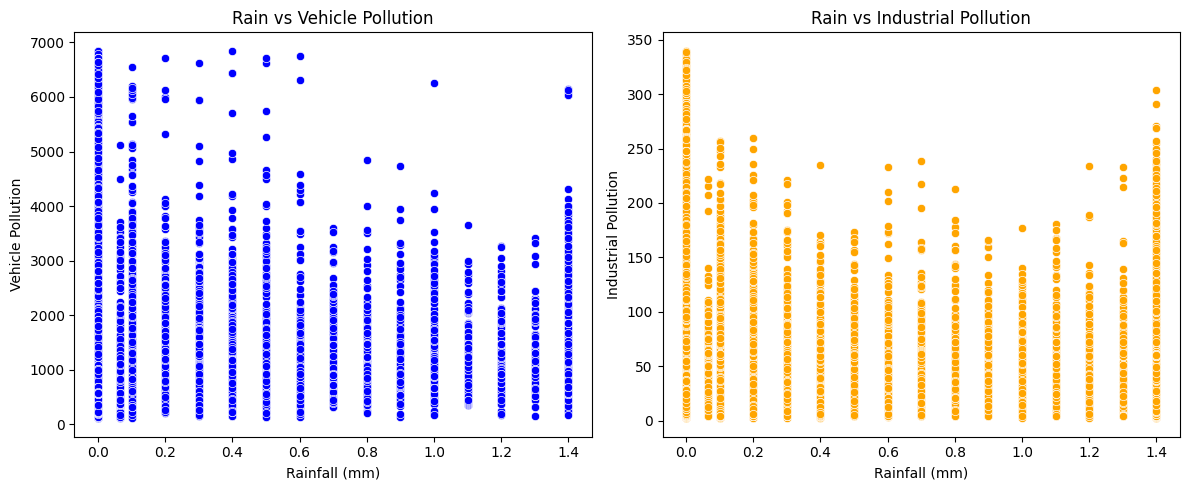

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Vehicle pollution
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='RAIN', y='vehicle_pollution', color='blue')
plt.title('Rain vs Vehicle Pollution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Vehicle Pollution')

# Industrial pollution
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='RAIN', y='industrial_pollution', color='orange')
plt.title('Rain vs Industrial Pollution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Industrial Pollution')

plt.tight_layout()
plt.show()


#### Seasonal Patterns of Temperature and Dewpoint

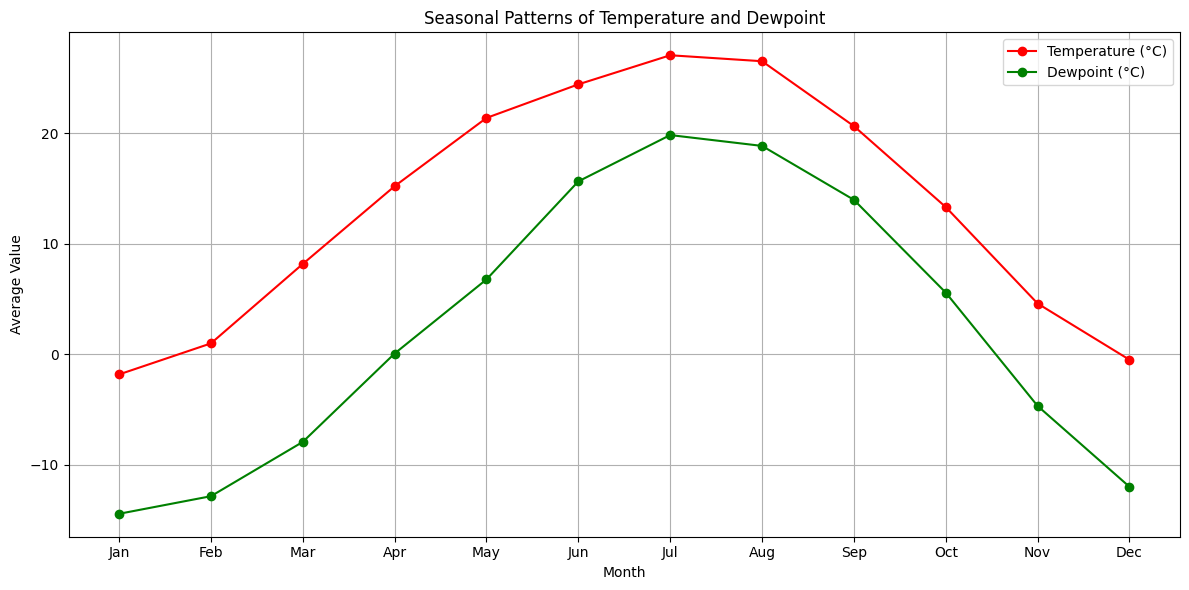

In [162]:
monthly_seasonal = df.groupby('month')[['TEMP', 'DEWP']].mean().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(monthly_seasonal['month'], monthly_seasonal['TEMP'], marker='o', label='Temperature (°C)', color='red')
plt.plot(monthly_seasonal['month'], monthly_seasonal['DEWP'], marker='o', label='Dewpoint (°C)', color='green')

plt.title('Seasonal Patterns of Temperature and Dewpoint')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Heatmap of correlations

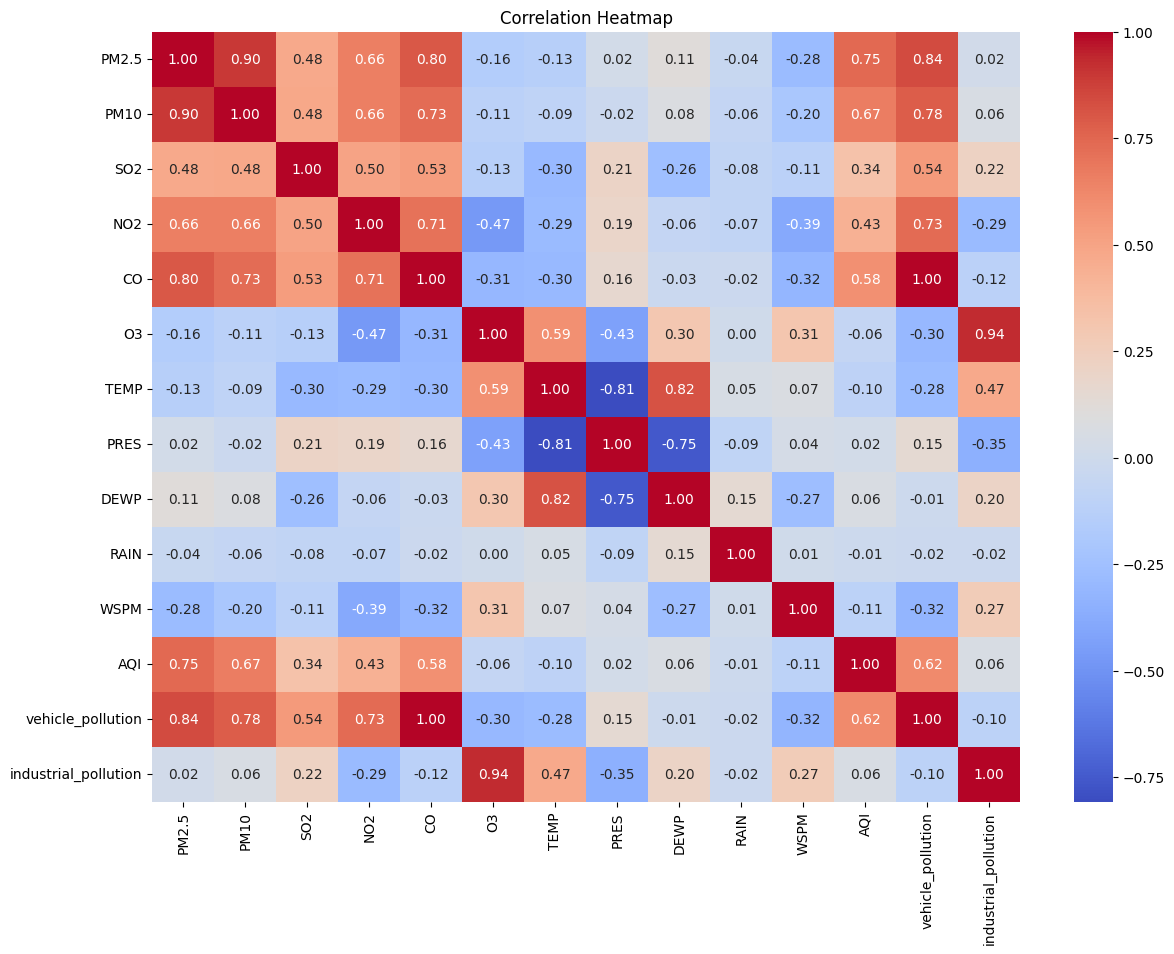

In [176]:
num_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'AQI', 'vehicle_pollution', 'industrial_pollution']

plt.figure(figsize=(14,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Task 03: Model Building